# Required Modules


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from getPicture import capturePicture
from random import randint

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv1D, Conv2D, MaxPool1D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, AveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

# **Generate Datasets**


In [3]:
positive_dir = Path('img/Positive')
negative_dir = Path('img/Negative')


def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')),
                          name='Filepath').astype(str)
    label = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, label], axis=1)
    return df


# Generate Datasets
positive_df = generate_df(positive_dir, label=1)
negative_df = generate_df(negative_dir, label=0)

# **Splitting Datasets**


In [4]:
# split_pct = 4/3
# X_train = pd.DataFrame({'Image': pd.concat([positive_df['Filepath'].iloc[:int(len(
#     positive_df)//split_pct)], negative_df['Filepath'].iloc[:int(len(negative_df)//split_pct)]], axis=0)})
# X_test = pd.DataFrame({'Image': pd.concat([positive_df['Filepath'].iloc[int(len(
#     positive_df)//split_pct):], negative_df['Filepath'].iloc[int(len(negative_df)//split_pct):]], axis=0)})
# y_train = pd.DataFrame({'Label': pd.concat([positive_df['Label'].iloc[:int(len(
#     positive_df)//split_pct)], negative_df['Label'].iloc[:int(len(negative_df)//split_pct)]], axis=0)})
# y_test = pd.DataFrame({'Label': pd.concat([positive_df['Label'].iloc[int(len(
#     positive_df)//split_pct):], negative_df['Label'].iloc[int(len(negative_df)//split_pct):]], axis=0)})

In [5]:
split_pct = 0.75

pos_train = positive_df.sample(frac=split_pct)
pos_test = positive_df.drop(pos_train.index)

neg_train = negative_df.sample(frac=split_pct)
neg_test = negative_df.drop(neg_train.index)

train = pd.concat([pos_train, neg_train])
test = pd.concat([pos_test, neg_test])
train.rename(columns = {'Filepath':'Image'}, inplace = True)
test.rename(columns = {'Filepath':'Image'}, inplace = True)

X_train = train['Image']
X_test = test['Label']
y_train = train['Image']
y_test = test['Label']

In [6]:
print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

Train size: 135
Test size: 45


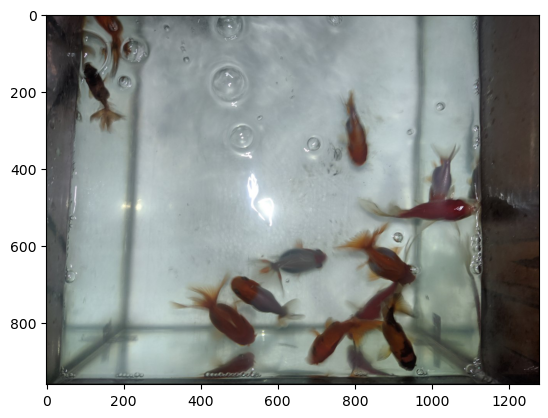

In [7]:
plt.imshow(plt.imread(X_train.iloc[randint(0, len(X_train)-1)]))
plt.show()

### Data Segmentation


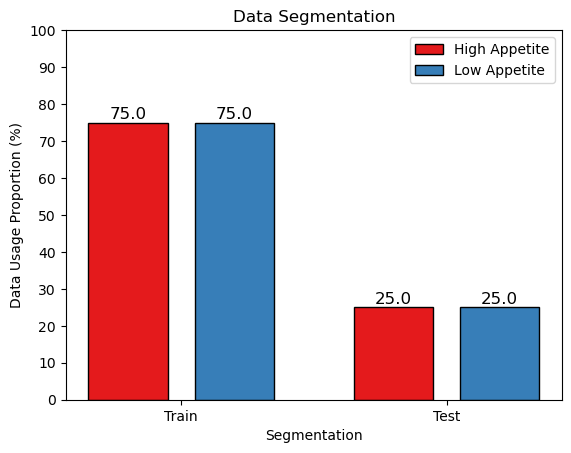

In [8]:
def addLabelLeft(x, y, pos):
    for i in range(len(x)):
        plt.text(i-pos, y[i]+1, round(y[i], 2), ha="center", fontsize=12)


X = ["Train", "Test"]
X_axis = np.arange(len(X))
high = [len(pos_train)/len(positive_df)*100, len(pos_test)/len(positive_df)*100]
low = [len(neg_train)/len(negative_df)*100, len(neg_test)/len(negative_df)*100]
plt.bar(X_axis - 0.2, high, 0.3, label='High Appetite',
        color="#E41A1C", edgecolor='black')
addLabelLeft(X_axis, high, 0.2)
plt.bar(X_axis + 0.2, low, 0.3, label='Low Appetite',
        color="#377EB8", edgecolor='black')
addLabelLeft(X_axis, low, -0.2)

plt.xticks(X_axis, X)
plt.xlabel("Segmentation")
plt.ylabel("Data Usage Proportion (%)")
plt.title("Data Segmentation")
plt.yticks(range(0, 101, 10))
plt.legend()
plt.show()

# Image Preparation


In [9]:
IMG_SIZE = 300
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   zoom_range=0.1,
                                   rotation_range = 0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)
val_datagen = ImageDataGenerator(rescale=1/255.)

train = train_datagen.flow_from_dataframe(train,
                                          x_col='Image',
                                          y_col='Label',
                                          target_size=(IMG_SIZE, IMG_SIZE),
                                          class_mode='raw',
                                          batch_size=32,
                                          seed=42)
test = train_datagen.flow_from_dataframe(test,
                                         x_col='Image',
                                         y_col='Label',
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='raw',
                                         batch_size=32,
                                         seed=42)

Found 135 validated image filenames.


Found 45 validated image filenames.


# Model


In [10]:
height = IMG_SIZE
width = IMG_SIZE
channel = 3
def prepareModel():
  model = keras.models.Sequential([
    Conv2D(filters=32,kernel_size=(3,3),strides=(3,3),activation='relu', name='Conv1',
           input_shape=(height,width,channel), 
           padding='same'),
    Conv2D(filters=32,kernel_size=(3,3), strides=(1,1),activation='relu', name='Conv2', padding='same'),    
    Conv2D(filters=64,kernel_size=(3,3),strides=(2,2),activation='relu', name='Conv3', padding='same'),
    Conv2D(filters=128,kernel_size=(3,3), strides=(2,2),activation='relu', name='Conv4', padding='same'),
    Conv2D(filters=256,kernel_size=(3,3), strides=(2,2),activation='relu', name='Conv5', padding='same'),
    MaxPool2D(pool_size=(2,2),strides=(3,3),padding='same', name="MaxPool1"),
    Flatten(),
    Dense(8, activation='relu', name="Dense"),
#     Dropout(0.25),
    Dense(1, activation='sigmoid', name="Output")
  ])
  return model

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0,
    mode='min',
    restore_best_weights=True)

epochs = 25
batch_size = 32
model = prepareModel()
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])
history = model.fit_generator(train,
                  validation_data = test,
#                   steps_per_epoch=len(train)//batch_size,
                  epochs=epochs,
                  )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 100, 100, 32)      896       
                                                                 
 Conv2 (Conv2D)              (None, 100, 100, 32)      9248      
                                                                 
 Conv3 (Conv2D)              (None, 50, 50, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 25, 25, 128)       73856     
                                                                 
 Conv5 (Conv2D)              (None, 13, 13, 256)       295168    
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 5, 5, 256)         0         
                                                                 
 flatten (Flatten)           (None, 6400)              0

C:\Users\Ellipsis\AppData\Local\Temp\ipykernel_21836\3667771328.py:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train,


Epoch 1/25
5/5 [==============================] - 27s 6s/step - loss: 0.6979 - accuracy: 0.4519 - val_loss: 0.6915 - val_accuracy: 0.5556
Epoch 2/25
5/5 [==============================] - 29s 7s/step - loss: 0.7006 - accuracy: 0.5556 - val_loss: 0.6911 - val_accuracy: 0.5556
Epoch 3/25
5/5 [==============================] - 20s 4s/step - loss: 0.6905 - accuracy: 0.5556 - val_loss: 0.6886 - val_accuracy: 0.5556
Epoch 4/25
5/5 [==============================] - 20s 4s/step - loss: 0.6877 - accuracy: 0.5556 - val_loss: 0.6838 - val_accuracy: 0.5556
Epoch 5/25
5/5 [==============================] - 20s 4s/step - loss: 0.6808 - accuracy: 0.5556 - val_loss: 0.6659 - val_accuracy: 0.5556
Epoch 6/25
5/5 [==============================] - 20s 4s/step - loss: 0.6579 - accuracy: 0.5556 - val_loss: 0.6266 - val_accuracy: 0.5556
Epoch 7/25
5/5 [==============================] - 38s 9s/step - loss: 0.6404 - accuracy: 0.6074 - val_loss: 0.5857 - val_accuracy: 0.7778
Epoch 8/25
5/5 [==================

# Evaluation

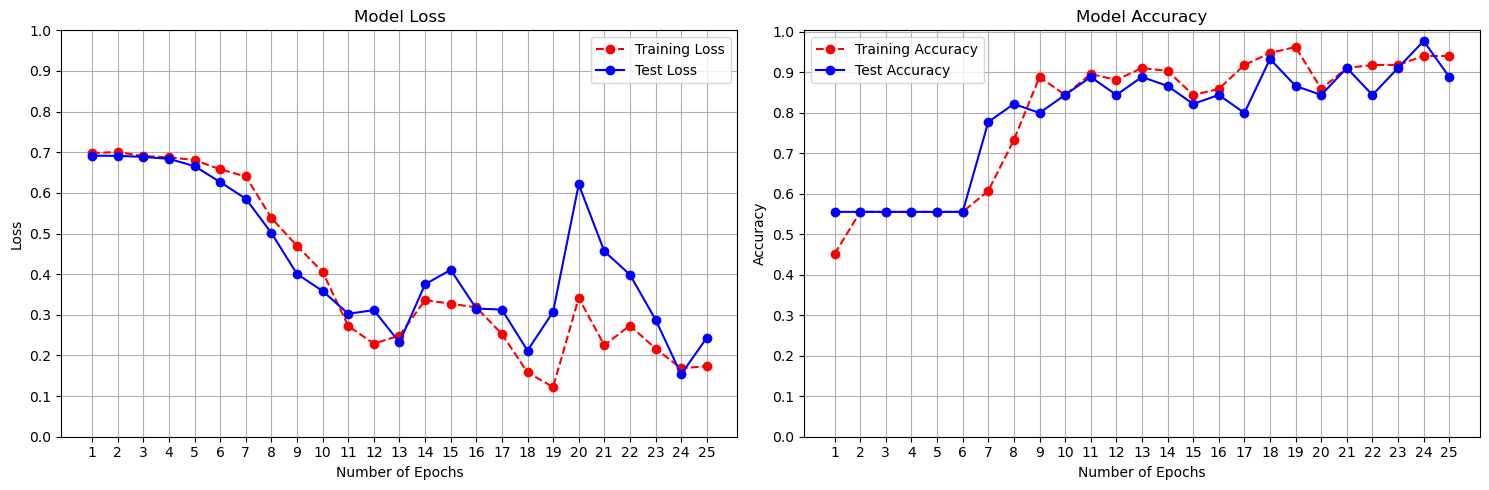

In [11]:
import matplotlib.pyplot as plt

# Assuming 'history' is defined and contains the necessary data

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
# Create count of the number of epochs
epoch_count = range(1, epochs+1)
bins_x = [i for i in range(1, epochs+1)]
bins_y = [i / 10 for i in range(0, 11)]  # Adjusted y-labels

# Visualize loss history
axes[0].plot(epoch_count, training_loss, 'r--', marker='o')
axes[0].plot(epoch_count, test_loss, 'b-', marker='o')
axes[0].legend(['Training Loss', 'Test Loss'])
axes[0].set_xlabel('Number of Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Model Loss')
axes[0].grid()
axes[0].set_xticks(epoch_count, bins_x)
axes[0].set_yticks(bins_y)  # Set y ticks
axes[0].set_yticklabels([f'{i:.1f}' for i in bins_y])  # Set y labels
# plt.show()

# Get training and test accuracy histories
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
# Create count of the number of epochs
# Visualize accuracy history
axes[1].plot(epoch_count, train_acc, 'r--', marker='o')
axes[1].plot(epoch_count, test_acc, 'b-', marker='o')
axes[1].legend(['Training Accuracy', 'Test Accuracy'])
axes[1].set_xlabel('Number of Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].grid()
axes[1].set_xticks(epoch_count, bins_x)
axes[1].set_yticks(bins_y)  # Set y ticks
axes[1].set_yticklabels([f'{i:.1f}' for i in bins_y])  # Set y labels
fig.tight_layout()
plt.show()

### Saving The Model

In [13]:
lst = os.listdir('models') # your directory path
number_files = len(lst)
model.save(f'models/PKM-KC_{number_files}.h5')

c:\Users\Ellipsis\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
